In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm

from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

Download:
For fasttext we want the `1. wiki-news-300d-1M.vec.zip: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).` found at 

`https://fasttext.cc/docs/en/english-vectors.html`

For GloVe we want the `Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip` found at 

`https://nlp.stanford.edu/projects/glove/`

In [29]:
def load_vectors_from_file(filename, n_words=20_000, encoding='utf-8', specified_word_set=None):
    p_bar = tqdm(total=n_words, desc='Loading word vectors', position=0, leave=True)
    embeddings_dict = {}
    with open(filename, 'r', encoding=encoding) as f:
        for line in f:
            values = line.split()
            word = values[0]
            if specified_word_set is None or word in specified_word_set:
                vector = np.asarray(values[1:], "float32")
                if len(vector) > 1:
                    embeddings_dict[word] = vector
                    p_bar.update(1)
                    if len(embeddings_dict) == n_words:
                        break
    print(f'Loaded {len(embeddings_dict)} word vectors')
    return embeddings_dict


def ensure_intersection_keys(dict1, dict2):
    """
    Modifies the input dictionaries to only keep keys that exist in both dictionaries.
    
    Parameters:
    dict1 (dict): The first dictionary to be modified.
    dict2 (dict): The second dictionary to be modified.
    """
    # Find the intersection of the keys
    common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    
    # Remove keys from dict1 that are not in the intersection
    keys_to_remove = set(dict1.keys()) - common_keys
    for key in keys_to_remove:
        del dict1[key]
    print(f'Removed {len(keys_to_remove)}, leaving {len(dict1.keys())}')

    # Remove keys from dict2 that are not in the intersection
    keys_to_remove = set(dict2.keys()) - common_keys
    for key in keys_to_remove:
        del dict2[key]

In [97]:
n_words = 200_000
filename_glove = join("glove.6B", "glove.6B.300d.txt")
embeddings_dict_glove = load_vectors_from_file(filename_glove, n_words=n_words)

Loading word vectors: 100%|██████████| 200000/200000 [00:17<00:00, 11534.75it/s]

Loaded 200000 word vectors


In [98]:
filename_fasttext = 'wiki-news-300d-1M.vec'
embeddings_dict_fasttext = load_vectors_from_file(filename_fasttext, n_words=n_words, specified_word_set=set(embeddings_dict_glove.keys()))

Loading word vectors:  56%|█████▌    | 112212/200000 [00:26<00:20, 4288.45it/s]

Loaded 112212 word vectors


In [99]:
ensure_intersection_keys(embeddings_dict_glove, embeddings_dict_fasttext)

Removed 87788, leaving 112212


In [100]:
def get_anchors(embeddings_dict, n_anchors=300):
    """Randomly sample n_anchors from embeddings_dict and return as a matrix where each row is a relative representation vector. Returns shape (embedding_dim, n_anchors)"""
    anchor_words = random.sample(list(embeddings_dict_fasttext.keys()), n_anchors)
    anchor_vectors = np.vstack([embeddings_dict[word] for word in anchor_words])
    
    return anchor_vectors

def get_relative_representations(embeddings_dict, similarity_measure, n_anchors=300):
    """Using a given similarity measure and embedding dictionary, calculate the relative representations and return as a matrix where each row is a relative representation vector. Returns shape (n_samples, n_anchors)"""
    relative_representations = []
    anchor_vectors = get_anchors(embeddings_dict, n_anchors=n_anchors)
    
    for word in tqdm(embeddings_dict.keys(), desc='Calculating relative representations',  position=0, leave=True):
        embedding = embeddings_dict[word]
        relative_representation = similarity_measure(embedding, anchor_vectors)
        relative_representations.append(relative_representation)
    data_vector = np.vstack(relative_representations)
    
    return data_vector

In [101]:
def cosine_similarity(word_vector, anchors):
    """Calculate the cosine similarity between the word vector and each of the anchors. Returns a vector of shape (n_anchors,)"""
    # Normalize the word vector
    word_vector_norm = np.linalg.norm(word_vector)
    word_vector_normalized = word_vector / word_vector_norm
    # Normalize the anchor rows
    row_norms = np.linalg.norm(anchors, axis=1)
    anchors_normalized = anchors / row_norms[:, np.newaxis]
    # Compute the cosine similarities (dot product of normalized word_vector and each row)
    cosine_similarities = np.dot(anchors_normalized, word_vector_normalized)
    
    return cosine_similarities

In [102]:
n_anchors = 300
random.seed(42)
relative_representations_glove = get_relative_representations(embeddings_dict_glove, n_anchors=n_anchors, similarity_measure=cosine_similarity)

Calculating relative representations: 100%|██████████| 112212/112212 [00:32<00:00, 3440.89it/s]


In [103]:
relative_representations_fasttext = get_relative_representations(embeddings_dict_fasttext, n_anchors=n_anchors, similarity_measure=cosine_similarity)

Calculating relative representations: 100%|██████████| 112212/112212 [00:30<00:00, 3675.97it/s]


In [110]:
def sample_cluster_centers(embedding_dict, n=5):
    random_sample = random.sample(list(embedding_dict.keys()), n)
    return np.array([embedding_dict[word] for word in random_sample])


def create_2d_clusters(cluster_centers, embeddings, n_neighbors=200):
    """
    Find the n_points nearest neighbors in the embeddings matrix for each cluster center and use PCA to reduce the dimensionality of the points to 2.
    
    Parameters:
    cluster_centers (np.array): An array of cluster center vectors.
    embeddings (np.array): An array of embedding vectors.
    n_neighbors (int): The number of nearest neighbors to find for each cluster center.
    
    Returns:
    pca_results: A numpy array of shape (n_clusters, n_neighbors, 2) containing the two principal components of the nearest neighbors of each of the clusters centers
    """
    pca_results = np.empty(shape=(cluster_centers.shape[0], n_neighbors, 2))
    
    # Fit the NearestNeighbors model
    nn_model = NearestNeighbors(n_neighbors=n_neighbors)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    nn_model.fit(embeddings_2d)
    
    for i, center in enumerate(cluster_centers):
        # Find the n_points nearest neighbors
        center_2d = pca.transform(center.reshape((1, -1)))
        distances, indices = nn_model.kneighbors(center_2d)
        nearest_neighbors = embeddings_2d[indices[0]]
                
        # Store the results in the dictionary
        pca_results[i] = nearest_neighbors
    
    return pca_results

def visualize_clusters(pca_results, name='', y_lim=(None,), x_lim=(None,)):
    for points in pca_results:
        plt.scatter(points[:, 0], points[:, 1], marker='o', s=2.5)
    plt.title(name)
    plt.ylim(*y_lim)
    plt.xlim(*x_lim)
    plt.grid(True)

In [111]:
n_centers = 3
n_points_visualisation = 100

centers_glove = sample_cluster_centers(embeddings_dict_glove, n=n_centers)
own_representations_glove = np.vstack(list(embeddings_dict_glove.values()))

centers_fasttext = sample_cluster_centers(embeddings_dict_glove, n=n_centers)
own_representations_fasttext = np.vstack(list(embeddings_dict_glove.values()))

In [112]:
pca_glove_own = create_2d_clusters(centers_glove, embeddings=own_representations_glove, n_neighbors=n_points_visualisation)

pca_fasttext_own = create_2d_clusters(centers_fasttext, embeddings=own_representations_fasttext, n_neighbors=n_points_visualisation)

pca_glove_relative = create_2d_clusters(centers_glove, embeddings=relative_representations_glove, n_neighbors=n_points_visualisation)

pca_fasttext_relative = create_2d_clusters(centers_fasttext, embeddings=relative_representations_fasttext, n_neighbors=n_points_visualisation)

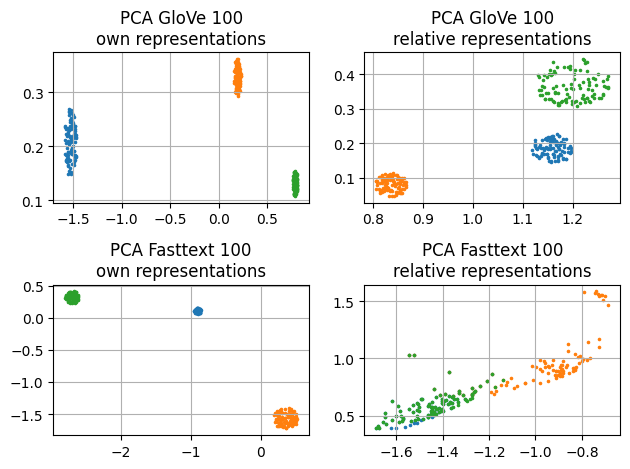

In [113]:
fig, axs = plt.subplots(nrows=2, ncols=2)
plt.sca(axs[0, 0])
visualize_clusters(pca_glove_own, f'PCA GloVe {n_points_visualisation}\nown representations')
plt.sca(axs[1, 0])
visualize_clusters(pca_fasttext_own, f'PCA Fasttext {n_points_visualisation}\nown representations')
plt.sca(axs[0, 1])
visualize_clusters(pca_glove_relative, f'PCA GloVe {n_points_visualisation}\nrelative representations')
plt.sca(axs[1, 1])
visualize_clusters(pca_fasttext_relative, f'PCA Fasttext {n_points_visualisation}\nrelative representations')

plt.tight_layout()

In [26]:
def jaccard_similarity(vector, matrix):
    """
    Calculate the Jaccard similarity between the vector and each of the rows in the matrix.
    
    Parameters:
    vector (np.array): A binary vector.
    matrix (np.array): A binary matrix with each row to be compared to the vector.
    
    Returns:
    np.array: A vector of Jaccard similarities of shape (n_anchors,).
    """
    # Ensure binary values
    vector = np.asarray(vector, dtype=bool)
    matrix = np.asarray(matrix, dtype=bool)
    
    # Calculate intersection and union
    intersection = np.logical_and(matrix, vector).sum(axis=1)
    union = np.logical_or(matrix, vector).sum(axis=1)
    
    # Handle the case of zero union (avoid division by zero)
    union[union == 0] = 1
    
    # Calculate Jaccard similarity
    jaccard_similarities = intersection / union
    
    return jaccard_similarities

def mean_reciprocal_rank(query_vector, matrix):
    """
    Calculate the Mean Reciprocal Rank (MRR) given a query vector and a matrix.
    
    Parameters:
    query_vector (np.array): A vector representing the query.
    matrix (np.array): A matrix where each row represents a document.
    
    Returns:
    float: The MRR score.
    """
    # Compute relevance scores as dot products between the query_vector and each row in the matrix
    relevance_scores = np.dot(matrix, query_vector)
    
    # Get the ranks of the documents sorted by relevance (highest relevance first)
    sorted_indices = np.argsort(relevance_scores)[::-1]
    
    # Find the rank of the first relevant document
    first_relevant_rank = np.where(sorted_indices == 0)[0][0] + 1  # Adding 1 to make rank 1-based
    
    # Calculate the reciprocal rank
    reciprocal_rank = 1 / first_relevant_rank
    
    return reciprocal_rank

In [27]:
def calculate_metrics(repr1, repr2, name1, name2, dict1, dict2, K=10):
    metrics_dict = defaultdict(lambda: [])
    knn1 = NearestNeighbors(n_neighbors=K)
    knn2 = NearestNeighbors(n_neighbors=K)
    knn1.fit(repr1)
    knn2.fit(repr2)
    
    nearest_neighbors1 = knn2.kneighbors(repr1, return_distance=False)
    for i, vect in tqdm(enumerate(repr1), desc=f'Calculating MRR for {name1}', leave=True, position=0, total=len(repr1)):
        metrics_dict[f'{name1}_MRR'].append(mean_reciprocal_rank(vect, repr2[nearest_neighbors1[i]]))
    nearest_neighbors1 = knn2.kneighbors(repr1, return_distance=False)
    for i, vect in tqdm(enumerate(repr2), desc=f'Calculating MRR for {name1}', leave=True, position=0, total=len(repr2)):
        metrics_dict[f'{name2}_MRR'].append(mean_reciprocal_rank(vect, repr1[nearest_neighbors1[i]]))
    
    for word in dict1.keys():
        cos_sim = np.dot(dict1[word], dict2[word])
        metrics_dict[f'cosine_similarity_glove_fasttext'].append(cos_sim)
        metrics_dict[f'cosine_similarity_fasttext_glove'].append(cos_sim)
    
    metrics_mean = {name: np.mean(list_) for name, list_ in metrics_dict.items()}
    return metrics_mean

In [28]:
calculate_metrics(repr1=relative_representations_glove, repr2=relative_representations_fasttext, name1='glove', name2='fasttext', dict1=embeddings_dict_glove, dict2=embeddings_dict_fasttext)

Calculating MRR for glove: 100%|██████████| 19316/19316 [00:00<00:00, 81853.89it/s]


{'glove_MRR': 0.16212698494873898,
 'fasttext_MRR': 0.70103742435747,
 'cosine_similarity_glove_fasttext': 0.09614079,
 'cosine_similarity_fasttext_glove': 0.09614079}